### Convert temperature to demand ###

Converting the daily observed (ERA5) and model (HadGEM3-GC31-MM) data into weather dependent electricity demand using Hannah's models.

Steps to do this are:

1. Find where the daily model and observations are stored
2. Ensure that the observed temp. data has had the regridding for the UK applied
3. Go through HDD and CDD steps

In [1]:
# Local imports
import os
import sys
import time
import argparse

# Third-party imports
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import shapely.geometry
import cartopy.io.shapereader as shpreader
import iris

# Specific imports
from tqdm import tqdm
from datetime import datetime, timedelta

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
# Hard coded args
model = "HadGEM3-GC31-MM"
experiment = "dcppA-hindcast"
freq = "day"
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# Set up the output directory for the dfs
output_dir_dfs = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_dfs"

In [3]:
# load the model data
df_model_tas = pd.read_csv(f"{output_dir_dfs}/HadGEM3-GC31-MM_dcppA-hindcast_tas_United_Kingdom_1960-2018_day.csv")

# load the obs data
df_obs_tas = pd.read_csv(f"{output_dir_dfs}/ERA5_tas_United_Kingdom_1960-2018_daily_2024-11-26.csv")

In [4]:
df_model_tas.head()

,init_year,member,lead,data
0,1960,1,1,283.904326
1,1960,1,2,281.653069
2,1960,1,3,280.558694
3,1960,1,4,280.931852
4,1960,1,5,280.171699


In [9]:
# int64 time(time) ;
#         time:long_name = "time" ;
#         time:units = "days since 1950-01-01 00:00:00" ;
#         time:calendar = "proleptic_gregorian" ;
# Assuming df_obs_tas is your DataFrame
# Convert the 'time' column to datetime, assuming it represents days since "1950-01-01 00:00:00"
df_obs_tas['time'] = pd.to_datetime(df_obs_tas['time'], origin='1950-01-01', unit='D')

# Display the DataFrame to verify the conversion
print(df_obs_tas.tail())

            time        data
21545 2018-12-27  280.410430
21546 2018-12-28  280.654895
21547 2018-12-29  281.870591
21548 2018-12-30  282.060577
21549 2018-12-31  282.126349


In [10]:
# Compare the distributions
df_obs_tas.head()

,time,data
0,1960-01-01,280.004414
1,1960-01-02,276.900436
2,1960-01-03,278.757843
3,1960-01-04,281.210861
4,1960-01-05,278.524161


In [11]:
# subset the obs data to O, N, D, J, F, M
df_obs_tas = df_obs_tas[df_obs_tas['time'].dt.month.isin([10, 11, 12, 1, 2, 3])]

In [12]:
# subset the model to the correct years
winter_years = np.arange(1, 10 + 1)

# set up a new df to append to
df_model_ondjfm= pd.DataFrame()

# Loop over the winter years
for i, wyear in enumerate(winter_years):
    # Set up the leads to extract
    leads = np.arange(331 + (i * 360), 331 + 180 + (i * 360))

    # Extract the data
    df_model_leads_this = df_model_tas[df_model_tas["lead"].isin(leads)]

    # include a new column

    # Append to the new df
    df_model_ondjfm = pd.concat([df_model_ondjfm, df_model_leads_this])

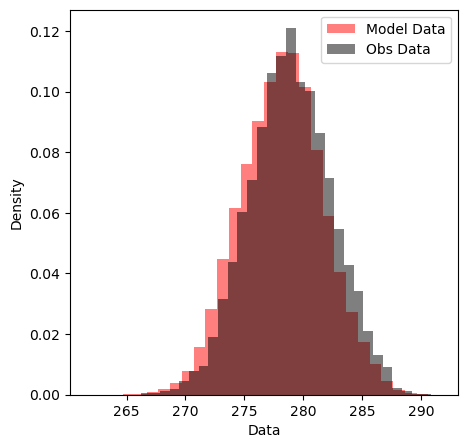

In [13]:
# Set up a figure
fig, ax = plt.subplots(figsize=(5, 5))


# Plot the normalized histogram of the model data in red
df_model_ondjfm['data'].plot(kind='hist', ax=ax, color='red', alpha=0.5, density=True, bins=30, label='Model Data')

# Plot the normalized histogram of the obs data in black
df_obs_tas['data'].plot(kind='hist', ax=ax, color='black', alpha=0.5, density=True, bins=30, label='Obs Data')

# Add labels and legend
ax.set_xlabel('Data')
ax.set_ylabel('Density')
ax.legend()

# Show the plot
plt.show()

In [14]:
df_obs_tas.head()

,time,data
0,1960-01-01,280.004414
1,1960-01-02,276.900436
2,1960-01-03,278.757843
3,1960-01-04,281.210861
4,1960-01-05,278.524161


In [15]:
# new column for temp in C
df_obs_tas['data_c'] = df_obs_tas['data'] - 273.15

In [16]:
# add a new column for temp c in the model data
df_model_ondjfm['data_c'] = df_model_ondjfm['data'] - 273.15

In [17]:
# Set up hdd and cdd
hdd_base = 15.5
cdd_base = 22.0

# Process the obs data
df_obs_tas['hdd'] = df_obs_tas['data_c'].apply(lambda x: max(0, hdd_base - x))
df_obs_tas['cdd'] = df_obs_tas['data_c'].apply(lambda x: max(0, x - cdd_base))

# process the model data
df_model_ondjfm['hdd'] = df_model_ondjfm['data_c'].apply(lambda x: max(0, hdd_base - x))
df_model_ondjfm['cdd'] = df_model_ondjfm['data_c'].apply(lambda x: max(0, x - cdd_base))

In [18]:
df_regr.head()

NameError: name 'df_regr' is not defined

In [19]:
# Set up the path to the regression coeffs
regr_coeffs = "/home/users/benhutch/ERA5_energy_update/ERA5_Regression_coeffs_demand_model.csv"

# load the regression coeffs
df_regr = pd.read_csv(regr_coeffs)

# Set the index
df_regr.set_index("Unnamed: 0", inplace=True)

# Rename the columns by splitting by _ and extracting the second element
df_regr.columns = [x.split("_")[0] for x in df_regr.columns]

# if there is a column called "United" replace it with "United Kingdom"
if "United" in df_regr.columns:
    df_regr.rename(columns={"United": "United_Kingdom"}, inplace=True)

# extract the coeffs for the UK
time_coeff_uk = df_regr.loc["time", "United_Kingdom"]
hdd_coeff_uk = df_regr.loc["HDD", "United_Kingdom"]
cdd_coeff_uk = df_regr.loc["CDD", "United_Kingdom"]

# Calculate the obs demand
df_obs_tas["UK_demand"] = (
    (time_coeff_uk * 2017) + # demand year which the model is based on
    (hdd_coeff_uk * df_obs_tas["hdd"]) +
    (cdd_coeff_uk * df_obs_tas["cdd"])
)

# Calculate the model demand
df_model_ondjfm["UK_demand"] = (
    (time_coeff_uk * 2017) + # demand year which the model is based on
    (hdd_coeff_uk * df_model_ondjfm["hdd"]) +
    (cdd_coeff_uk * df_model_ondjfm["cdd"])
)

In [20]:
df_obs_tas.head()

,time,data,data_c,hdd,cdd,UK_demand
0,1960-01-01,280.004414,6.854414,8.645586,0,41.519602
1,1960-01-02,276.900436,3.750436,11.749564,0,43.840163
2,1960-01-03,278.757843,5.607843,9.892157,0,42.451549
3,1960-01-04,281.210861,8.060861,7.439139,0,40.617652
4,1960-01-05,278.524161,5.374161,10.125839,0,42.626252


In [21]:
df_model_ondjfm.head()

,init_year,member,lead,data,data_c,hdd,cdd,UK_demand
330,1960,1,331,283.344633,10.194633,5.305367,0,39.022425
331,1960,1,332,284.247110,11.097110,4.402890,0,38.347726
332,1960,1,333,284.948156,11.798156,3.701844,0,37.823617
333,1960,1,334,284.529038,11.379038,4.120962,0,38.136953
334,1960,1,335,284.921268,11.771268,3.728732,0,37.843719


In [22]:
# Load my specific functions
sys.path.append("/home/users/benhutch/unseen_functions")
from functions import plot_distributions_fidelity, plot_cdfs, plot_qq

In [24]:
# plot_distributions_fidelity(
#     obs_df=df_obs_tas,
#     model_df=df_model_ondjfm,
#     obs_val_name="UK_demand",
#     model_val_name="UK_demand",
#     obs_time_name="time",
#     model_time_name="init_year",
#     model_member_name="member",
#     model_lead_name="lead",
#     title="Distribution ONDJFM UK Demand (GW)",
#     nboot=1000,
#     figsize=(12, 6),
#     fname_prefix="UK_demand_ondjfm_distribution_fidelity_1960-2018",
#     save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
# )

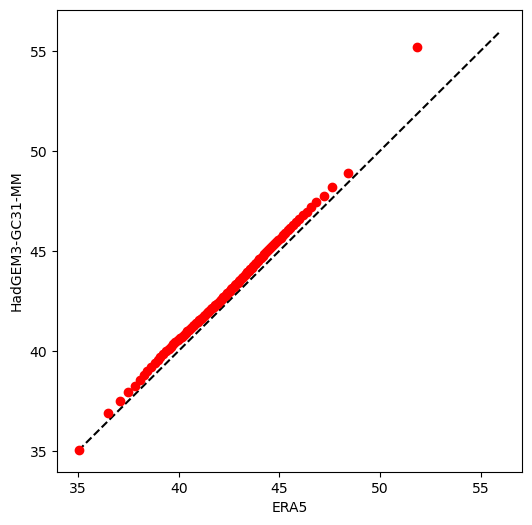

In [25]:
plot_qq(
    obs_df=df_obs_tas,
    model_df=df_model_ondjfm,
    obs_val_name="UK_demand",
    model_val_name="UK_demand",
    save_prefix="UK_demand_ondjfm_qq_1960-2018",
    save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
)

The ks stat is 0.07268210675845205
The ks p is 2.3935815847874098e-49
at alpha = 0.05, the critical value is 0.013181404756669374
at alpha = 0.01, the critical value is 0.01579830128924344
The null hypothesis is rejected at the 1% level
The two samples are not drawn from the same distribution
The null hypothesis is rejected at the 1% level
The two samples are not drawn from the same distribution


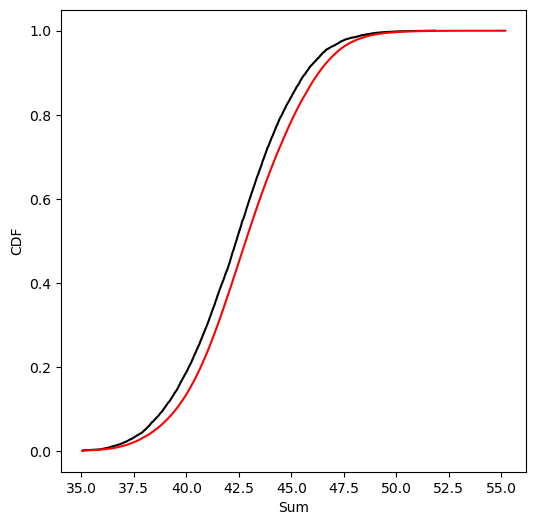

In [26]:
plot_cdfs(
    obs_df=df_obs_tas,
    model_df=df_model_ondjfm,
    obs_val_name="UK_demand",
    model_val_name="UK_demand",
    save_prefix="UK_demand_ondjfm_cdf_1960-2018",
    save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
)

In [27]:
df_obs_tas.head()

,time,data,data_c,hdd,cdd,UK_demand
0,1960-01-01,280.004414,6.854414,8.645586,0,41.519602
1,1960-01-02,276.900436,3.750436,11.749564,0,43.840163
2,1960-01-03,278.757843,5.607843,9.892157,0,42.451549
3,1960-01-04,281.210861,8.060861,7.439139,0,40.617652
4,1960-01-05,278.524161,5.374161,10.125839,0,42.626252


Text(0.5, 1.0, 'Boxplots of UK demand (GW) for United Kingdom ONDJFM 1960-2018 HadGEM3-GC31-MM dcppA-hindcast day')

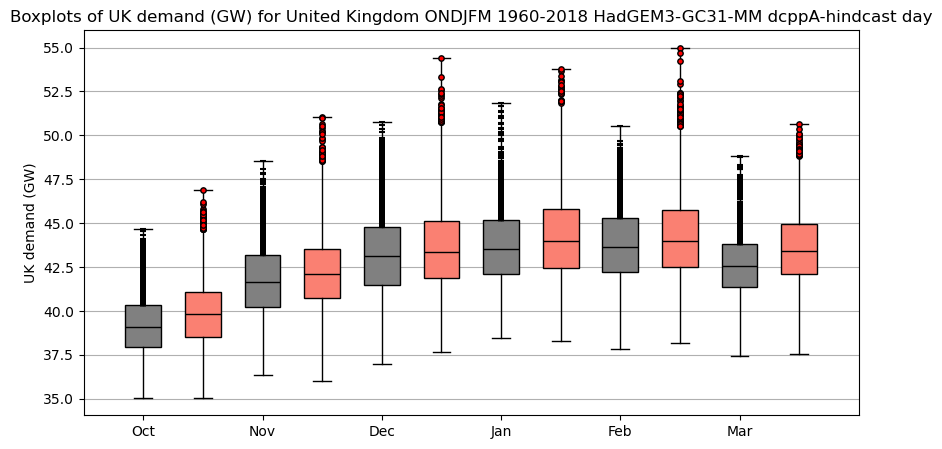

In [28]:
# Set up the name
obs_val_name = "UK_demand"
model_val_name = "UK_demand"
variable = "UK demand (GW)"

# plot the boxplots for the different months
# set up the figure size
plt.figure(figsize=(10, 5))

# Set up the month names for the x-axis
month_names = ["Oct", "Nov", "Dec", "Jan", "Feb", "Mar"]

# Set up the ylabel
plt.ylabel(f"{variable}")

# Set up the lead_years
lead_years = np.arange(1, 11)

# set ip the months
months = [10, 11, 12, 1, 2, 3]

# assert that months is 10, 11, 12, 1, 2, 3
assert months == [10, 11, 12, 1, 2, 3], "Months not recognised"

# # if variable is tas, convert to C
# if variable == "tas":
#     df_obs_tas[obs_val_name] = df_obs_tas[obs_val_name] - 273.15
#     df_model_ondjfm[model_val_name] = df_model_ondjfm[model_val_name] - 273.15

# Loop over the months
for i, month in enumerate(months):
    # subset to the month
    obs_df_month = df_obs_tas[df_obs_tas["time"].dt.month == month]

    leads_this_month = []

    # find the leads to extract
    for j, ly in enumerate(lead_years):
        # set up the leads
        leads_this_month = np.arange(331 + (j * 360) + (i * 30), 331 + 30 + (j * 360) + (i * 30))


    # subset to the leads
    model_df_month = df_model_ondjfm[df_model_ondjfm["lead"].isin(leads_this_month)]

    # Calculate the upper quartile (75th percentile)
    obs_lower_quartile = np.percentile(obs_df_month[obs_val_name], 25)
    obs_upper_quartile = np.percentile(obs_df_month[obs_val_name], 75)
    model_lower_quartile = np.percentile(model_df_month[model_val_name], 25)

    # calculate the obs min value for the month
    obs_min = np.min(obs_df_month[obs_val_name])
    obs_max = np.max(obs_df_month[obs_val_name])

    # Plot the observed data in black
    obs_box = plt.boxplot(
        obs_df_month[obs_val_name],
        positions=[i + 1],
        widths=0.3,
        showfliers=False,
        boxprops=dict(color='black'),
        capprops=dict(color='black'),
        whiskerprops=dict(color='black'),
        flierprops=dict(markerfacecolor='black', marker='o'),
        medianprops=dict(color='black'),
        whis=[0, 100], # the 0th and 100th percentiles (i.e. min and max)
        patch_artist=True
    )

    # Set the face color for the observed data box
    for box in obs_box['boxes']:
        box.set(facecolor='grey')

    # Plot the model data in red
    model_box = plt.boxplot(
        model_df_month[model_val_name],
        positions=[i + 1.5],
        widths=0.3,
        showfliers=False,
        boxprops=dict(color='black'),
        capprops=dict(color='black'),
        whiskerprops=dict(color='black'),
        flierprops=dict(markerfacecolor='black', marker='o'),
        medianprops=dict(color='black'),
        whis=[0, 100], # the 0th and 100th percentiles (i.e. min and max)
        patch_artist=True,
    )

    # Set the face color for the model data box
    for box in model_box['boxes']:
        box.set(facecolor='salmon')    

    # add scatter points for obs values beneath the lower quartile
    obs_below_lower_quartile = obs_df_month[obs_val_name][obs_df_month[obs_val_name] < obs_lower_quartile]
    obs_above_upper_quartile = obs_df_month[obs_val_name][obs_df_month[obs_val_name] > obs_upper_quartile]

    plt.scatter(
        [i + 1] * len(obs_above_upper_quartile),
        obs_above_upper_quartile,
        color="black",
        marker="_",
        s=15,
        zorder=10,
    )

    # # add scatter points for model values beneath the lower quartile
    # model_below_lower_quartile = model_df_month[model_val_name][model_df_month[model_val_name] < model_lower_quartile]
    # plt.scatter(
    #     [i + 1.5] * len(model_below_lower_quartile),
    #     model_below_lower_quartile,
    #     color="red",
    #     marker="_",
    #     s=20,
    # )

    # add red dots for the points which are lower than the obs min
    model_below_obs_min = model_df_month[model_val_name][model_df_month[model_val_name] < obs_min]
    model_above_obs_max = model_df_month[model_val_name][model_df_month[model_val_name] > obs_max]

    # plot the model data
    plt.scatter(
        [i + 1.5] * len(model_above_obs_max),
        model_above_obs_max,
        color="red",
        edgecolor="black",
        marker="o",
        s=15,
        zorder=10,
    )

# include gridlines
plt.grid(axis="y")

# set the xticks
plt.xticks(ticks=np.arange(1, 7), labels=month_names)

# Set up the season
season = "ONDJFM"
first_year = 1960
last_year = 2018
country = "United Kingdom"

# set the title
plt.title(f"Boxplots of {variable} for {country} {season} {first_year}-{last_year} HadGEM3-GC31-MM {experiment} {freq}")

Now we want to look at the no. days within the winter which exceed a specific threshold (e.g. the 92th percentile) and also the severity. First we should apply a simple mean bias correction to the model demand.

In [29]:
df_obs_tas.columns

Index(['time', 'data', 'data_c', 'hdd', 'cdd', 'UK_demand'], dtype='object')

In [30]:
# ensure that time is pd.datetime
df_obs_tas["time"] = pd.to_datetime(df_obs_tas["time"])

# set as the index
df_obs_tas.set_index("time", inplace=True)

In [31]:
# Therefore use the 92th percentile for exceedance
# loop over the winter years
winter_years = np.arange(1960, 2018 + 1)

# Set up an array to store the severity index
severity_index = np.zeros(len(winter_years))

# Set up an array to store the no. exceedance days
no_exceedance_days = np.zeros(len(winter_years))

# Set up an empty list for the dates
dates_exceedance_values = []
exceedance_values = []
winter_mean_dnw = []

all_winters_92 = np.percentile(df_obs_tas["UK_demand"], 92)

# loop over the winter years
for i, year in enumerate(winter_years):
    # Set up the first and last day of the winter
    winter_start = pd.Timestamp(f"{year}-10-01")
    winter_end = pd.Timestamp(f"{year+1}-03-31")

    # subset the data
    df = df_obs_tas.loc[winter_start:winter_end]

    # if df includes 29th feb, then drop this row
    if f"{year + 1}-02-29" in df.index:
        print("Dropping 29th Feb")
        df = df.drop(pd.Timestamp(f"{year + 1}-02-29"))

    # apply a boolean mask to the demand net wind value
    # which is true where the demand net wind is greater than the 80% tile value
    mask = df["UK_demand"] > all_winters_92

    # # plot the data as a grey line
    # ax.plot(index_date, df["UK_demand"], color="grey", alpha=0.2)

    # # plot the masked values as red dots
    # ax.plot(index_date[mask], df["UK_demand"][mask], "rx")

    # calculate the severity index
    severity_index[i] = (df["UK_demand"][mask] - all_winters_92).sum()

    # calculate the no. exceedance days
    no_exceedance_days[i] = mask.sum()

    # calculate the mean demand net wind for the winter
    winter_mean_dnw.append(df["UK_demand"].mean())

    # format the dates to yyyy-mm-dd
    dates = df.index[mask].strftime("%Y-%m-%d")

    # Add the dates and values to the list
    dates_exceedance_values.extend(df.index[mask])

    # Add the exceedance values to the list
    exceedance_values.extend(df["UK_demand"][mask])

# set up a dataframe for the number of exceedance days
df_exceedance_days_obs = pd.DataFrame(
    {
        "severity": severity_index,
        "no_exceedance_days": no_exceedance_days,
        "winter_mean_dnw": winter_mean_dnw,
    },
    index=winter_years,
)

Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb


In [32]:
# print the row with the max value for no. exceedance days
print(df_exceedance_days_obs.loc[df_exceedance_days_obs["no_exceedance_days"].idxmax()])

# print the row with the max value for severity index
print(df_exceedance_days_obs.loc[df_exceedance_days_obs["severity"].idxmax()])

severity              155.333629
no_exceedance_days     74.000000
winter_mean_dnw        44.543478
Name: 1962, dtype: float64
severity              155.333629
no_exceedance_days     74.000000
winter_mean_dnw        44.543478
Name: 1962, dtype: float64


In [33]:
df_model_ondjfm.head()

,init_year,member,lead,data,data_c,hdd,cdd,UK_demand
330,1960,1,331,283.344633,10.194633,5.305367,0,39.022425
331,1960,1,332,284.247110,11.097110,4.402890,0,38.347726
332,1960,1,333,284.948156,11.798156,3.701844,0,37.823617
333,1960,1,334,284.529038,11.379038,4.120962,0,38.136953
334,1960,1,335,284.921268,11.771268,3.728732,0,37.843719


In [34]:
# subset the model to the correct years
winter_years = np.arange(1, 10 + 1)

# set up a new df to append to
df_model_ondjfm_wyear = pd.DataFrame()

# Loop over the winter years
for i, wyear in enumerate(winter_years):
    # Set up the leads to extract
    leads = np.arange(331 + (i * 360), 331 + 180 + (i * 360))

    # Extract the data
    df_model_leads_this = df_model_ondjfm[df_model_ondjfm["lead"].isin(leads)]

    # include a new column containing the winter year
    df_model_leads_this["winter_year"] = wyear

    # Append to the new df
    df_model_ondjfm_wyear = pd.concat([df_model_ondjfm_wyear, df_model_leads_this])

/tmp/ipykernel_721901/1433218824.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model_leads_this["winter_year"] = wyear
/tmp/ipykernel_721901/1433218824.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model_leads_this["winter_year"] = wyear
/tmp/ipykernel_721901/1433218824.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

In [35]:
# Apply a mean bias correction to the model data
# Calculate the mean bias
mean_bias = df_obs_tas["UK_demand"].mean() - df_model_ondjfm_wyear["UK_demand"].mean()

# Apply the mean bias correction
df_model_ondjfm_wyear["UK_demand_bc"] = df_model_ondjfm_wyear["UK_demand"] + mean_bias

# # apply this corrected to the 05 and 95 percentiles
# df_model_ondjfm_wyear["UK_demand"] = df_model_ondjfm_wyear["wd_demand_net_wind_pred_05"] + mean_bias
# df_model_ondjfm_wyear["wd_demand_net_wind_pred_95_bc"] = df_model_ondjfm_wyear["wd_demand_net_wind_pred_95"] + mean_bias

In [36]:
# Extract the unique init years
init_years = df_model_ondjfm_wyear["init_year"].unique()
members = df_model_ondjfm_wyear["member"].unique()
winter_years = df_model_ondjfm_wyear["winter_year"].unique()

# Set up an array to store the severity index
model_severity_index = np.zeros([len(init_years), len(members), len(winter_years)])
model_no_exceedance_days = np.zeros([len(init_years), len(members), len(winter_years)])

# Set up an empty list for the dates
model_dates_exceedance_values = []
model_exceedance_values = []
winter_mean_dnw = []

# Set up an empty df
df_model_exceedance = pd.DataFrame()

# loop over the init years
for i, i_year in enumerate(init_years):
    for j, member in enumerate(members):
        for k, w_year in enumerate(winter_years):
            # Constrain to the init year, member and winter year
            df_this = df_model_ondjfm_wyear[
                (df_model_ondjfm_wyear["init_year"] == i_year)
                & (df_model_ondjfm_wyear["member"] == member)
                & (df_model_ondjfm_wyear["winter_year"] == w_year)
            ]

            # apply a boolean mask to the demand net wind value
            # which is true where the demand net wind is greater than the 80% tile value
            mask = df_this["UK_demand_bc"] > all_winters_92

            # calculate the severity index
            model_severity_index[i, j, k] = (df_this["UK_demand_bc"][mask] - all_winters_92).sum()

            # calculate the no. exceedance days
            model_no_exceedance_days[i, j, k] = mask.sum()

            # # winter mean values
            # winter_mean_dnw.append(df_this["wd_demand_net_wind_pred_bc"].mean())

            # Set up the df
            df_this_exceedance = pd.DataFrame(
                {
                    "init_year": [i_year],
                    "member": [member],
                    "winter_year": [w_year],
                    "severity": [model_severity_index[i, j, k]],
                    "no_exceedance_days": [model_no_exceedance_days[i, j, k]],
                }
            )

            # Append to the df
            df_model_exceedance = pd.concat([df_model_exceedance, df_this_exceedance])

In [37]:
# create a new column in df_model_exceedance
# effective dec_year
df_model_exceedance["effective_dec_year"] = df_model_exceedance["init_year"] + df_model_exceedance["winter_year"]

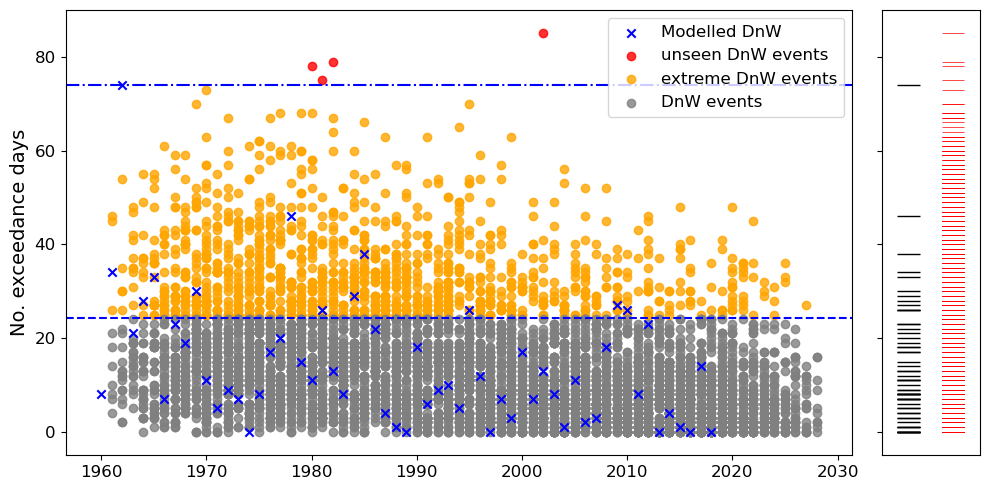

In [38]:
import seaborn as sns

# Set up the figure
fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(10, 5),
    sharey=True,
    gridspec_kw={"width_ratios": [8, 1]},
)

# add a horizontal line for the 0.8 quantile of the observations
axs[0].axhline(
    np.quantile(df_exceedance_days_obs["no_exceedance_days"], 0.8),
    color="blue",
    linestyle="--",
)

# for the max value of the obs
axs[0].axhline(
    np.max(df_exceedance_days_obs["no_exceedance_days"]),
    color="blue",
    linestyle="-.",
)

# plot the scatter points for the obs
axs[0].scatter(
    df_exceedance_days_obs.index,
    df_exceedance_days_obs["no_exceedance_days"],
    color="blue",
    marker="x",
    label="Modelled DnW",
    zorder=2,
)

# Separate model data by threshold
very_bad_events = df_model_exceedance[
    df_model_exceedance["no_exceedance_days"] > np.max(df_exceedance_days_obs["no_exceedance_days"])
]

# Model data above 80th percentile
bad_events = df_model_exceedance[
    (df_model_exceedance["no_exceedance_days"] > np.quantile(df_exceedance_days_obs["no_exceedance_days"], 0.8)) &
    (df_model_exceedance["no_exceedance_days"] < np.max(df_exceedance_days_obs["no_exceedance_days"]))
]

# Model data below 80th percentile
events = df_model_exceedance[
    df_model_exceedance["no_exceedance_days"] < np.quantile(df_exceedance_days_obs["no_exceedance_days"], 0.8)
]

# Plot the points below the minimum of the obs
axs[0].scatter(
    very_bad_events["effective_dec_year"],
    very_bad_events["no_exceedance_days"],
    color="red",
    alpha=0.8,
    label="unseen DnW events",
)

# Plot the points below the 20th percentile
axs[0].scatter(
    bad_events["effective_dec_year"],
    bad_events["no_exceedance_days"],
    color="orange",
    alpha=0.8,
    label="extreme DnW events",
)

# Plot the points above the 20th percentile
axs[0].scatter(
    events["effective_dec_year"],
    events["no_exceedance_days"],
    color="grey",
    alpha=0.8,
    label="DnW events",
)

# # for the most extreme evnts
# # plot the error bars
# axs[0].errorbar(
#     very_bad_events["effective_dec_year"],
#     very_bad_events["no_exceedance_days"],
#     yerr=[
#         very_bad_events["no_exceedance_days"] - very_bad_events["no_exceedance_days_05"],  # lower errors
#         very_bad_events["no_exceedance_days_95"] - very_bad_events["no_exceedance_days"],  # upper errors
#     ],
#     fmt="none",
#     ecolor="red",
#     capsize=5,
#     zorder=1,
# )

# include the legend
axs[0].legend(fontsize=12)

# label the y-axis
axs[0].set_ylabel("No. exceedance days", fontsize=14)

# set up the x-axis

# increase the size of the value labels
axs[0].tick_params(axis="x", labelsize=12)

# same for the y-axis
axs[0].tick_params(axis="y", labelsize=12)

# set up the ylims
axs[0].set_ylim(-5, 90)

# do the events plots for the no. exceedance days on the second plot
axs[1].eventplot(
    df_exceedance_days_obs["no_exceedance_days"],
    colors="black",
    lineoffsets=0,
    linelengths=0.5,
    orientation="vertical",
    linewidths=1,
    label="Observed",
)

# plot the model data
axs[1].eventplot(
    df_model_exceedance["no_exceedance_days"],
    colors="red",
    lineoffsets=1,
    linelengths=0.5,
    orientation="vertical",
    linewidths=0.5,
    label="Model",
)

# # set up the xlabels for the second plot
# xlabels = ["Observed", "Model"]

# # add the xlabels to the second subplot
# axs[1].set_xticks(xlabels)

# # remove the xlabel
# axs[1].set_xlabel("")

# # remove the yticks and axis lin
# axs[1].set_yticks([])

# remove the xticks from the second plot
axs[1].set_xticks([])

# specify a tight layout
plt.tight_layout()

# set up a fname for the plot
fname = "no_exceedance_days_uk_demand_1960-2018.pdf"

save_dir = "/home/users/benhutch/unseen_multi_year/plots"

# form the savepath
savepath = os.path.join(save_dir, fname)

if not os.path.exists(savepath):
    # save the plot
    plt.savefig(savepath, bbox_inches="tight", dpi=800)


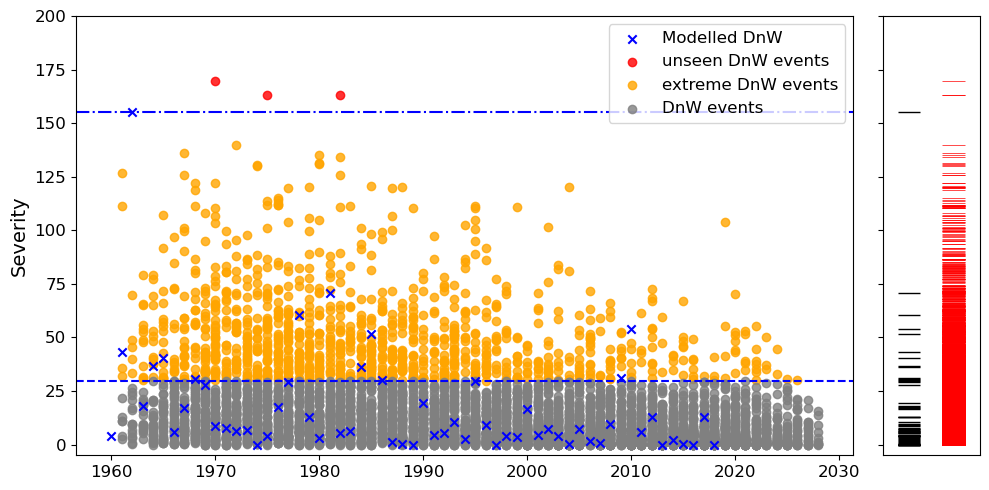

In [39]:
import seaborn as sns

# Set up the figure
fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(10, 5),
    sharey=True,
    gridspec_kw={"width_ratios": [8, 1]},
)

# add a horizontal line for the 0.8 quantile of the observations
axs[0].axhline(
    np.quantile(df_exceedance_days_obs["severity"], 0.8),
    color="blue",
    linestyle="--",
)

# for the max value of the obs
axs[0].axhline(
    np.max(df_exceedance_days_obs["severity"]),
    color="blue",
    linestyle="-.",
)

# plot the scatter points for the obs
axs[0].scatter(
    df_exceedance_days_obs.index,
    df_exceedance_days_obs["severity"],
    color="blue",
    marker="x",
    label="Modelled DnW",
    zorder=2,
)

# Separate model data by threshold
very_bad_events = df_model_exceedance[
    df_model_exceedance["severity"] > np.max(df_exceedance_days_obs["severity"])
]

# Model data above 80th percentile
bad_events = df_model_exceedance[
    (df_model_exceedance["severity"] > np.quantile(df_exceedance_days_obs["severity"], 0.8)) &
    (df_model_exceedance["severity"] < np.max(df_exceedance_days_obs["severity"]))
]

# Model data below 80th percentile
events = df_model_exceedance[
    df_model_exceedance["severity"] < np.quantile(df_exceedance_days_obs["severity"], 0.8)
]

# Plot the points below the minimum of the obs
axs[0].scatter(
    very_bad_events["effective_dec_year"],
    very_bad_events["severity"],
    color="red",
    alpha=0.8,
    label="unseen DnW events",
)

# Plot the points below the 20th percentile
axs[0].scatter(
    bad_events["effective_dec_year"],
    bad_events["severity"],
    color="orange",
    alpha=0.8,
    label="extreme DnW events",
)

# Plot the points above the 20th percentile
axs[0].scatter(
    events["effective_dec_year"],
    events["severity"],
    color="grey",
    alpha=0.8,
    label="DnW events",
)

# for the most extreme evnts
# # plot the error bars
# axs[0].errorbar(
#     very_bad_events["effective_dec_year"],
#     very_bad_events["severity"],
#     yerr=[
#         very_bad_events["severity"] - very_bad_events["severity_05"],  # lower errors
#         very_bad_events["severity_95"] - very_bad_events["severity"],  # upper errors
#     ],
#     fmt="none",
#     ecolor="red",
#     capsize=5,
#     zorder=1,
# )

# include the legend
axs[0].legend(fontsize=12)

# label the y-axis
axs[0].set_ylabel("Severity", fontsize=14)

# set up the x-axis

# increase the size of the value labels
axs[0].tick_params(axis="x", labelsize=12)

# same for the y-axis
axs[0].tick_params(axis="y", labelsize=12)

# set up the ylims
axs[0].set_ylim(-5, 200)

# do the events plots for the no. exceedance days on the second plot
axs[1].eventplot(
    df_exceedance_days_obs["severity"],
    colors="black",
    lineoffsets=0,
    linelengths=0.5,
    orientation="vertical",
    linewidths=1,
    label="Observed",
)

# plot the model data
axs[1].eventplot(
    df_model_exceedance["severity"],
    colors="red",
    lineoffsets=1,
    linelengths=0.5,
    orientation="vertical",
    linewidths=0.5,
    label="Model",
)

# # set up the xlabels for the second plot
# xlabels = ["Observed", "Model"]

# # add the xlabels to the second subplot
# axs[1].set_xticks(xlabels)

# # remove the xlabel
# axs[1].set_xlabel("")

# # remove the yticks and axis lin
# axs[1].set_yticks([])

# remove the xticks from the second plot
axs[1].set_xticks([])

# specify a tight layout
plt.tight_layout()

# set up a fname for the plot
fname = "severity_uk_demand_1960-2018.pdf"

save_dir = "/home/users/benhutch/unseen_multi_year/plots"

# form the savepath
savepath = os.path.join(save_dir, fname)

if not os.path.exists(savepath):
    # save the plot
    plt.savefig(savepath, bbox_inches="tight", dpi=800)


Now perform the EVA for the demand data to explore the return period of known extremes

In [41]:
sys.path.append("/home/users/benhutch/unseen_functions")
from functions import empirical_return_level

In [42]:
import matplotlib
import warnings
from scipy.stats import genextreme as gev

# silence the warnings
warnings.filterwarnings("ignore")

# Set up the probabilities
probs = 1 / np.arange(1.1, 1000, 0.1) * 100

years = np.arange(1.1, 1000, 0.1)

# assuming ONDJFM
# set up the lead years
lead_years = np.arange(1, 11)

# set up the months
months = [10, 11, 12, 1, 2, 3]

# Set up the number of samples
n_samples = 1000

# Quantify the return levels
# For the number of exceedance days
model_df_rl = empirical_return_level(
    data=df_model_exceedance["no_exceedance_days"].values,
    high_values_rare=True,
)

# print the head of the model_df_rl
print(model_df_rl.head())

# reverse the order of the rows
model_df_rl_inverse = model_df_rl.iloc[::-1]

# print the head of the model_df_rl_inverse
print(model_df_rl_inverse.head())

# Create an array to store the return levels
model_rl = np.zeros([n_samples, len(model_df_rl)])
obs_rl = np.zeros([n_samples, len(df_exceedance_days_obs)])

# Set up the model params
model_params = []
obs_params = []
model_params_first = []

model_params_first.append(
    gev.fit(
        df_model_exceedance["no_exceedance_days"],
    )
)

# Loop over the no. samples
for i in tqdm(range(n_samples)):
    # Sample the model data
    model_vals_this = np.random.choice(
        df_model_exceedance["no_exceedance_days"],
        size=len(model_df_rl["sorted"]),
        replace=True,
    )

    # set up the obs vals this
    obs_vals_this = np.random.choice(
        df_exceedance_days_obs["no_exceedance_days"],
        size=len(df_exceedance_days_obs["no_exceedance_days"]),
        replace=True,
    )

    # Quantify the empirical return levels
    model_df_rl_this = empirical_return_level(
        data=model_vals_this,
        high_values_rare=True,
    )

    # Quantify the return levels using the gev
    model_params.append(
        gev.fit(
            model_vals_this,
        )
    )

    # Set up the obs return levels
    obs_params.append(
        gev.fit(
            obs_vals_this,
        )
    )

    # Store the model return levels
    model_rl[i, :] = model_df_rl_this["sorted"]


levels_model = []
levels_obs = []

# loop over the num_samples
for i in range(n_samples):
    # Generate the ppf fit
    levels_model.append(
        np.array(gev.ppf(
            1 - 1 / years,
            *model_params[i],
        ))
    )

    # Generate the ppf fit
    levels_obs.append(
        np.array(gev.ppf(
            1 - 1 / years,
            *obs_params[i],
        ))
    )

# # Generate the ppf fit
levels_model_first = np.array(gev.ppf(
    1 - 1 / years,
    *model_params_first[0],
))


      sorted  rank_sp  exceedance    period  probability
5899     0.0   5900.0    0.999831  1.000169    99.983054
5898     0.0   5899.0    0.999661  1.000339    99.966107
5897     0.0   5898.0    0.999492  1.000509    99.949161
5896     0.0   5897.0    0.999322  1.000678    99.932215
5895     0.0   5896.0    0.999153  1.000848    99.915269
   sorted  rank_sp  exceedance     period  probability
0    85.0    129.0    0.021861  45.744186      2.18607
1    79.0    129.0    0.021861  45.744186      2.18607
2    78.0    129.0    0.021861  45.744186      2.18607
3    75.0    129.0    0.021861  45.744186      2.18607
4    73.0    129.0    0.021861  45.744186      2.18607


100%|██████████| 1000/1000 [01:56<00:00,  8.58it/s]


In [44]:
probs

array([90.90909091, 83.33333333, 76.92307692, ...,  0.10003001,
        0.10002   ,  0.10001   ])

In [47]:
# convert probs to return levels in years
return_years = 1 / (probs / 100)

In [48]:
return_years

array([  1.1,   1.2,   1.3, ..., 999.7, 999.8, 999.9])

In [65]:
sys.path.append("/home/users/benhutch/unseen_functions")
from functions import estimate_period

In [67]:
model_params_first[0]

(np.float64(-0.2018140932890777),
 np.float64(8.861950249296473),
 np.float64(8.135601919274029))

In [70]:
model_params_array = np.array(model_params)

Model estimate for worst observed event: 99.15107551882477
Model estimate for worst observed event 2.5th percentile: 99.0483050057716
Model estimate for worst observed event 97.5th percentile: 99.27255787329679
Return period for worst observed event: 117.79610815506543
Return period for worst observed event 2.5th percentile: 105.07568139630295
Return period for worst observed event 97.5th percentile: 137.46798037831874


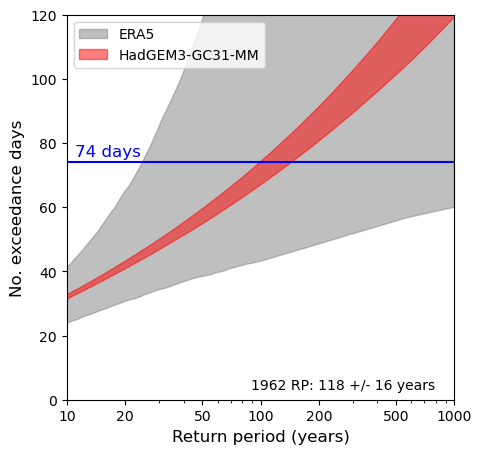

In [87]:
# Set up the figure
fig, ax = plt.subplots(figsize=(5, 5))

# plot the observed return levels
_ = ax.fill_between(
    return_years,
    np.quantile(levels_obs, 0.025, axis=0).T,
    np.quantile(levels_obs, 0.975, axis=0).T,
    color="gray",
    alpha=0.5,
    label="ERA5",
)

# plot the model return levels
_ = ax.fill_between(
    return_years,
    np.quantile(levels_model, 0.025, axis=0).T,
    np.quantile(levels_model, 0.975, axis=0).T,
    color="red",
    alpha=0.5,
    label="HadGEM3-GC31-MM",
)

# Set up a logarithmic x-axis
ax.set_xscale("log")

# Limit to between 10 and 1000 years
ax.set_xlim(10, 1000)

# Set the xticks at 10, 20, 50, 100, 200, 500, 1000
plt.xticks([10, 20, 50, 100, 200, 500, 1000], ["10", "20", "50", "100", "200", "500", "1000"])

# Set the ylim
ax.set_ylim(0, 120)

# Set the ylabel
ax.set_ylabel("No. exceedance days", fontsize=12)

# set the xlabel
ax.set_xlabel("Return period (years)", fontsize=12)

# include the value of the worst obs event with a horizontal line
ax.axhline(
    np.max(df_exceedance_days_obs["no_exceedance_days"]),
    color="blue",
    linestyle="-",
)

# Include text on this line for the value
ax.text(
    11,
    np.max(df_exceedance_days_obs["no_exceedance_days"]) + 2,
    f"{round(np.max(df_exceedance_days_obs['no_exceedance_days']))} days",
    color="blue",
    fontsize=12,
)

# Quantify the return level for the worst obs event
model_est_worst_obs = estimate_period(
    return_level=np.max(df_exceedance_days_obs["no_exceedance_days"]),
    loc=model_params_first[0][1],
    scale=model_params_first[0][2],
    shape=model_params_first[0][0],
)

# Same but for the 2.5th percentile
model_est_worst_obs_025 = estimate_period(
    return_level=np.max(df_exceedance_days_obs["no_exceedance_days"]),
    loc=np.percentile(model_params[:, 1], 2.5),
    scale=np.percentile(model_params[:, 2], 2.5),
    shape=np.percentile(model_params[:, 0], 2.5),
)

# Same but for the 97.5th percentile
model_est_worst_obs_975 = estimate_period(
    return_level=np.max(df_exceedance_days_obs["no_exceedance_days"]),
    loc=np.percentile(model_params[:, 1], 97.5),
    scale=np.percentile(model_params[:, 2], 97.5),
    shape=np.percentile(model_params[:, 0], 97.5),
)

# print these values
print(f"Model estimate for worst observed event: {model_est_worst_obs}")
print(f"Model estimate for worst observed event 2.5th percentile: {model_est_worst_obs_025}")
print(f"Model estimate for worst observed event 97.5th percentile: {model_est_worst_obs_975}")

# process into estiates
worst_event = 1 - (model_est_worst_obs / 100)
worst_event_025 = 1 - (model_est_worst_obs_025 / 100)
worst_event_975 = 1 - (model_est_worst_obs_975 / 100)

# Calculate the return period
rp_worst_event = 1 / worst_event
rp_worst_event_025 = 1 / worst_event_025
rp_worst_event_975 = 1 / worst_event_975

# print these values
print(f"Return period for worst observed event: {rp_worst_event}")
print(f"Return period for worst observed event 2.5th percentile: {rp_worst_event_025}")
print(f"Return period for worst observed event 97.5th percentile: {rp_worst_event_975}")

central_95 = abs(rp_worst_event_975 - rp_worst_event_025) / 2

# include a textbox in the top right with the return period of the worst observed event
ax.text(
    0.95,
    0.02,
    f"1962 RP: {round(rp_worst_event)} +/- {round(central_95)} years",
    horizontalalignment="right",
    verticalalignment="bottom",
    transform=ax.transAxes,
    fontsize=10,
    # bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"),
)

# include a legend in the top left
ax.legend(fontsize=10, loc='upper left')

In [88]:
# Same but for severity
# silence the warnings
warnings.filterwarnings("ignore")

# Set up the probabilities
probs = 1 / np.arange(1.1, 1000, 0.1) * 100

years = np.arange(1.1, 1000, 0.1)

# assuming ONDJFM
# set up the lead years
lead_years = np.arange(1, 11)

# set up the months
months = [10, 11, 12, 1, 2, 3]

# Set up the number of samples
n_samples = 1000

# Quantify the return levels
# For the number of exceedance days
model_df_rl = empirical_return_level(
    data=df_model_exceedance["severity"].values,
    high_values_rare=True,
)

# print the head of the model_df_rl
print(model_df_rl.head())

# reverse the order of the rows
model_df_rl_inverse = model_df_rl.iloc[::-1]

# print the head of the model_df_rl_inverse
print(model_df_rl_inverse.head())

# Create an array to store the return levels
model_rl = np.zeros([n_samples, len(model_df_rl)])
obs_rl = np.zeros([n_samples, len(df_exceedance_days_obs)])

# Set up the model params
model_params = []
obs_params = []
model_params_first = []

model_params_first.append(
    gev.fit(
        df_model_exceedance["severity"],
    )
)

# Loop over the no. samples
for i in tqdm(range(n_samples)):
    # Sample the model data
    model_vals_this = np.random.choice(
        df_model_exceedance["severity"],
        size=len(model_df_rl["sorted"]),
        replace=True,
    )

    # set up the obs vals this
    obs_vals_this = np.random.choice(
        df_exceedance_days_obs["severity"],
        size=len(df_exceedance_days_obs["severity"]),
        replace=True,
    )

    # Quantify the empirical return levels
    model_df_rl_this = empirical_return_level(
        data=model_vals_this,
        high_values_rare=True,
    )

    # Quantify the return levels using the gev
    model_params.append(
        gev.fit(
            model_vals_this,
        )
    )

    # Set up the obs return levels
    obs_params.append(
        gev.fit(
            obs_vals_this,
        )
    )

    # Store the model return levels
    model_rl[i, :] = model_df_rl_this["sorted"]


levels_model = []
levels_obs = []

# loop over the num_samples
for i in range(n_samples):
    # Generate the ppf fit
    levels_model.append(
        np.array(gev.ppf(
            1 - 1 / years,
            *model_params[i],
        ))
    )

    # Generate the ppf fit
    levels_obs.append(
        np.array(gev.ppf(
            1 - 1 / years,
            *obs_params[i],
        ))
    )

# # Generate the ppf fit
levels_model_first = np.array(gev.ppf(
    1 - 1 / years,
    *model_params_first[0],
))


      sorted  rank_sp  exceedance    period  probability
5899     0.0   5900.0    0.999831  1.000169    99.983054
5898     0.0   5899.0    0.999661  1.000339    99.966107
5897     0.0   5898.0    0.999492  1.000509    99.949161
5896     0.0   5897.0    0.999322  1.000678    99.932215
5895     0.0   5896.0    0.999153  1.000848    99.915269
       sorted  rank_sp  exceedance     period  probability
0  169.472729    129.0    0.021861  45.744186      2.18607
1  163.301015    129.0    0.021861  45.744186      2.18607
2  163.059183    129.0    0.021861  45.744186      2.18607
3  139.852103    129.0    0.021861  45.744186      2.18607
4  136.028521    129.0    0.021861  45.744186      2.18607


100%|██████████| 1000/1000 [02:20<00:00,  7.11it/s]


Model estimate for worst observed event: 97.7468793503702
Model estimate for worst observed event 2.5th percentile: 97.5159899355431
Model estimate for worst observed event 97.5th percentile: 97.96191624878507
Return period for worst observed event: 44.38288735955192
Return period for worst observed event 2.5th percentile: 40.25748584149312
Return period for worst observed event 97.5th percentile: 49.065697099242776


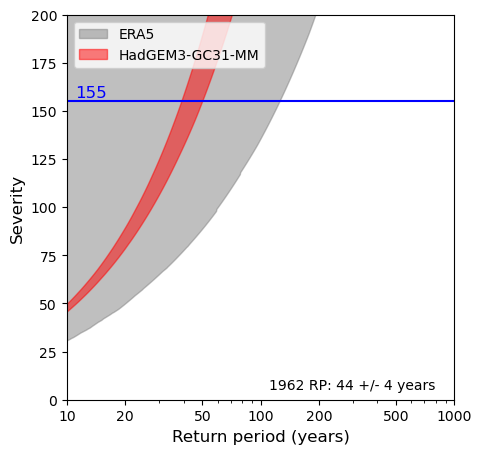

In [97]:
# Set up the figure
fig, ax = plt.subplots(figsize=(5, 5))

# plot the observed return levels
_ = ax.fill_between(
    return_years,
    np.quantile(levels_obs, 0.025, axis=0).T,
    np.quantile(levels_obs, 0.975, axis=0).T,
    color="gray",
    alpha=0.5,
    label="ERA5",
)

# plot the model return levels
_ = ax.fill_between(
    return_years,
    np.quantile(levels_model, 0.025, axis=0).T,
    np.quantile(levels_model, 0.975, axis=0).T,
    color="red",
    alpha=0.5,
    label="HadGEM3-GC31-MM",
)


# plot the empirical return levels in black
# _ = ax.plot(
#     1 / (model_df_rl["probability"] / 100),
#     model_df_rl["sorted"],
#     color="black",
#     label="Empirical",
# )

# Set up a logarithmic x-axis
ax.set_xscale("log")

# Limit to between 10 and 1000 years
ax.set_xlim(10, 1000)

# Set the xticks at 10, 20, 50, 100, 200, 500, 1000
plt.xticks([10, 20, 50, 100, 200, 500, 1000], ["10", "20", "50", "100", "200", "500", "1000"])

# Set the ylim
ax.set_ylim(0, 200)

# Set the ylabel
ax.set_ylabel("Severity", fontsize=12)

# set the xlabel
ax.set_xlabel("Return period (years)", fontsize=12)

# include the value of the worst obs event with a horizontal line
ax.axhline(
    np.max(df_exceedance_days_obs["severity"]),
    color="blue",
    linestyle="-",
)

# Include text on this line for the value
ax.text(
    11,
    np.max(df_exceedance_days_obs["severity"]) + 2,
    f"{round(np.max(df_exceedance_days_obs['severity']))}",
    color="blue",
    fontsize=12,
)

# Quantify the return level for the worst obs event
model_est_worst_obs = estimate_period(
    return_level=np.max(df_exceedance_days_obs["severity"]),
    loc=model_params_first[0][1],
    scale=model_params_first[0][2],
    shape=model_params_first[0][0],
)

# if model params is not an array
if not isinstance(model_params, np.ndarray):
    model_params = np.array(model_params)

# Same but for the 2.5th percentile
model_est_worst_obs_025 = estimate_period(
    return_level=np.max(df_exceedance_days_obs["severity"]),
    loc=np.percentile(model_params[:, 1], 2.5),
    scale=np.percentile(model_params[:, 2], 2.5),
    shape=np.percentile(model_params[:, 0], 2.5),
)

# Same but for the 97.5th percentile
model_est_worst_obs_975 = estimate_period(
    return_level=np.max(df_exceedance_days_obs["severity"]),
    loc=np.percentile(model_params[:, 1], 97.5),
    scale=np.percentile(model_params[:, 2], 97.5),
    shape=np.percentile(model_params[:, 0], 97.5),
)

# print these values
print(f"Model estimate for worst observed event: {model_est_worst_obs}")
print(f"Model estimate for worst observed event 2.5th percentile: {model_est_worst_obs_025}")
print(f"Model estimate for worst observed event 97.5th percentile: {model_est_worst_obs_975}")

# process into estiates
worst_event = 1 - (model_est_worst_obs / 100)
worst_event_025 = 1 - (model_est_worst_obs_025 / 100)
worst_event_975 = 1 - (model_est_worst_obs_975 / 100)

# Calculate the return period
rp_worst_event = 1 / worst_event
rp_worst_event_025 = 1 / worst_event_025
rp_worst_event_975 = 1 / worst_event_975

# print these values
print(f"Return period for worst observed event: {rp_worst_event}")
print(f"Return period for worst observed event 2.5th percentile: {rp_worst_event_025}")
print(f"Return period for worst observed event 97.5th percentile: {rp_worst_event_975}")

central_95 = abs(rp_worst_event_975 - rp_worst_event_025) / 2

# include a textbox in the top right with the return period of the worst observed event
ax.text(
    0.95,
    0.02,
    f"1962 RP: {round(rp_worst_event)} +/- {round(central_95)} years",
    horizontalalignment="right",
    verticalalignment="bottom",
    transform=ax.transAxes,
    fontsize=10,
    # bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"),
)

# include a legend in the top left
ax.legend(fontsize=10, loc='upper left')

Now process how the likelihood of extreme events is changing over time.

In [102]:
%%time

num_samples = 1000

decades = np.arange(1960, 2030, 10)

decade_years = []

# Set up the decade years
for i, decade in enumerate(decades):
    if i == 0:
        decade_years.append(np.arange(decade, decade + 11))
    else:
        decade_years.append(np.arange(decade + 1, decade + 11))

# Flatten the list of arrays into a single list
flattened_years = np.concatenate(decade_years)

# Filter out the years not in df_model_exceedance["effective_dec_year"].unique()
filtered_years = [year for year in flattened_years if year in df_model_exceedance["effective_dec_year"].unique()]

# Reshape the filtered list back into the original decade structure
filtered_decade_years = []
for i, decade in enumerate(decades):
    if i == 0:
        filtered_decade_years.append(np.array([year for year in filtered_years if 1960 <= year <= 1970]))
    else:
        filtered_decade_years.append(np.array([year for year in filtered_years if decade + 1 <= year <= decade + 10]))

# try the same but with the empirical return levels
# extract the unique winter years from the model df
unique_winter_years = df_model_exceedance["effective_dec_year"].unique()

# find the year of the highest value for no exceedance days
# in the observed data
# Assuming df_exceedance_days_obs is your DataFrame
max_year = df_exceedance_days_obs.loc[
    df_exceedance_days_obs["no_exceedance_days"].idxmax()
].name

# Print the max year
print("The year with the greatest no. exceedance days is: ", max_year)
print("The value is: ", df_exceedance_days_obs["no_exceedance_days"].max())

# set up params year
decade_params = np.zeros([len(filtered_decade_years), num_samples, 3])

# Loop over the unique winter years
for i, decade in tqdm(enumerate(filtered_decade_years)):
    # Subset the model data to the decade years
    df_model_exceedance_this = df_model_exceedance[
        df_model_exceedance["effective_dec_year"].isin(decade)
    ]

    # initialise the list of params
    params_decade = np.zeros([num_samples, 3])

    # Loop over the samples
    for j in range(num_samples):
        params_decade[j, :] = gev.fit(
            np.random.choice(
                df_model_exceedance_this["no_exceedance_days"],
                size=len(df_model_exceedance_this),
                replace=True,
            )
        )

    # append the params to the model year
    decade_params[i, :, :] = params_decade

The year with the greatest no. exceedance days is:  1962
The value is:  74.0


7it [04:40, 40.09s/it]

CPU times: user 4min 37s, sys: 606 ms, total: 4min 38s
Wall time: 4min 40s


In [104]:
# Set up the array for mean, 2.5th and 97.5th percentiles
period_decade_mean = np.zeros([len(filtered_decade_years)])
period_decade_025 = np.zeros([len(filtered_decade_years)])
period_decade_975 = np.zeros([len(filtered_decade_years)])

# find the value for the observed worst event
obs_worst_event = df_exceedance_days_obs["no_exceedance_days"].max()

# loop over the unique years to fit the ppfs
for i, decade in tqdm(enumerate(filtered_decade_years)):
    # Subset the params for the decade
    params_decade = decade_params[i, :, :]

    # Estimate the period for the model mean data
    period_decade_mean[i] = estimate_period(
        return_level=obs_worst_event,
        loc=np.mean(params_decade[:, 1]),
        scale=np.mean(params_decade[:, 2]),
        shape=np.mean(params_decade[:, 0]),
    )

    # model 025 percentile
    period_decade_025[i] = estimate_period(
        return_level=obs_worst_event,
        loc=np.percentile(params_decade[:, 1], 2.5),
        scale=np.percentile(params_decade[:, 2], 2.5),
        shape=np.percentile(params_decade[:, 0], 2.5),
    )

    # model 95 percentile
    period_decade_975[i] = estimate_period(
        return_level=obs_worst_event,
        loc=np.percentile(params_decade[:, 1], 97.5),
        scale=np.percentile(params_decade[:, 2], 97.5),
        shape=np.percentile(params_decade[:, 0], 97.5),
    )

# put these into a dataframe with the years
model_df_rl = pd.DataFrame(
    {
        "decade": decades,
        "mean": period_decade_mean,
        "025": period_decade_025,
        "975": period_decade_975,
    }
)

7it [00:00, 1252.19it/s]


In [105]:
# for each row of "mean", "025", "975" calculate the return period
# 1 / (1 - (100 - value))
model_df_rl["mean_rp (%)"] = 1 - (model_df_rl["mean"] / 100)
model_df_rl["025_rp (%)"] = 1 - (model_df_rl["025"] / 100)
model_df_rl["975_rp (%)"] = 1 - (model_df_rl["975"] / 100)

# calculate the return period in years of the observed worst event
model_df_rl["mean_rp (years)"] = 1 / model_df_rl["mean_rp (%)"]
model_df_rl["025_rp (years)"] = 1 / model_df_rl["025_rp (%)"]
model_df_rl["975_rp (years)"] = 1 / model_df_rl["975_rp (%)"]

The year with the greatest no_exceedance_days index is:  1962


Text(0.5, 1.0, 'Return period of the worst no. exceedance days event (74, 1962)')

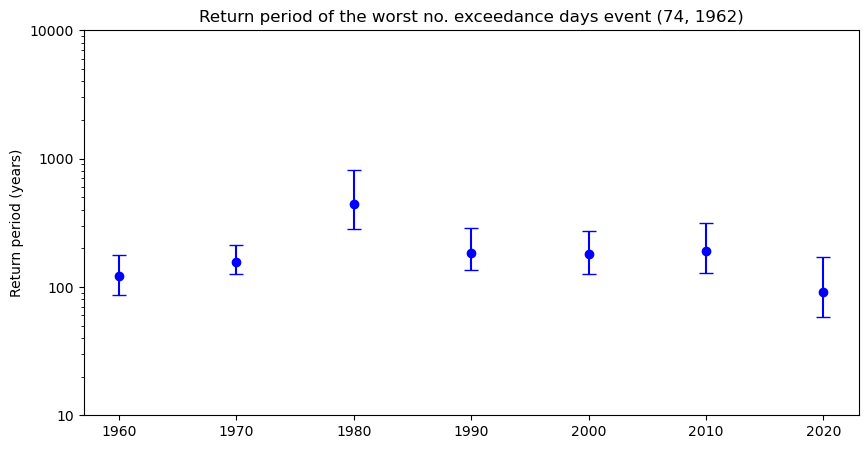

In [107]:
# plot the mean rp values with error bars for the 025 and 975 percentiles
plt.figure(figsize=(10, 5))

# plot the mean
plt.scatter(
    model_df_rl["decade"],
    model_df_rl["mean_rp (years)"],
    color="blue",
    label="Mean",
)

# plot the 025 and 975 percentiles
plt.errorbar(
    model_df_rl["decade"],
    model_df_rl["mean_rp (years)"],
    yerr=[
        model_df_rl["mean_rp (years)"] - model_df_rl["025_rp (years)"], # lower errors
        model_df_rl["975_rp (years)"] - model_df_rl["mean_rp (years)"], # upper errors
    ],
    fmt="none",
    ecolor="blue",
    capsize=5,
)

# set up a log yscale
plt.yscale("log")

# Set up the y ticks
plt.yticks([10, 100, 1000, 10000], ["10", "100", "1000", "10000"])

# set up the y axis labels
plt.ylabel("Return period (years)")

# find the year of the highest value for no exceedance days
# in the observed data
max_year = df_exceedance_days_obs.loc[
    df_exceedance_days_obs["no_exceedance_days"].idxmax()
].name

# print max year
print("The year with the greatest no_exceedance_days index is: ", max_year)

# # set up the title
# Set up the title
plt.title(
    f"Return period of the worst no. exceedance days event ({round(df_exceedance_days_obs['no_exceedance_days'].max())}, {max_year})"
)

Text(0.5, 1.0, 'Return period of the worst no. exceedance days event (74, 1962)')

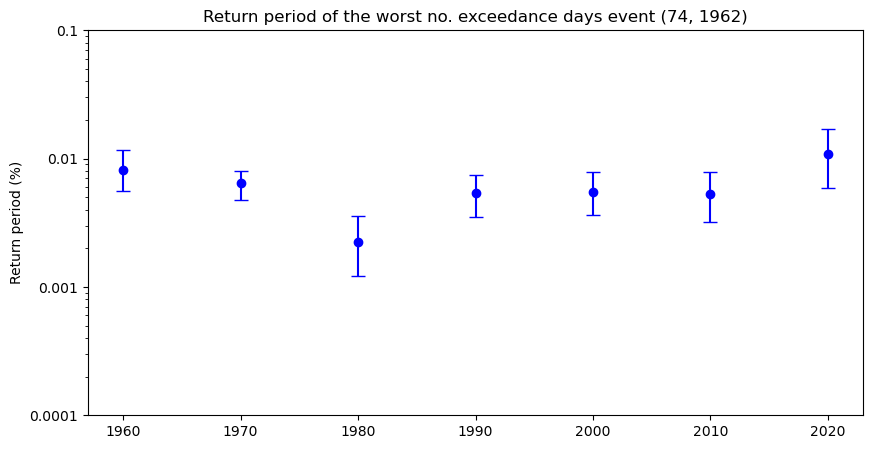

In [108]:
# Set up the figure
plt.figure(figsize=(10, 5))

# plot scatter of decade vs mean return period (%)
plt.scatter(
    model_df_rl["decade"],
    model_df_rl["mean_rp (%)"],
    color="blue",
    label="Mean",
)

# plot the 025 and 975 percentiles
plt.errorbar(
    model_df_rl["decade"],
    model_df_rl["mean_rp (%)"],
    yerr=[
        model_df_rl["mean_rp (%)"] - model_df_rl["975_rp (%)"], # lower errors
        model_df_rl["025_rp (%)"] - model_df_rl["mean_rp (%)"], # upper errors
    ],
    fmt="none",
    ecolor="blue",
    capsize=5,
)

# set up the yscale
plt.yscale("log")

# set up the yticks
plt.yticks([0.0001, 0.001, 0.01, 0.1], ["0.0001", "0.001", "0.01", "0.1"])

# set up the ylabel
plt.ylabel("Return period (%)")

# set up the title
plt.title(
    f"Return period of the worst no. exceedance days event ({round(df_exceedance_days_obs['no_exceedance_days'].max())}, {max_year})"
)

Now for changes in severity over time.

In [109]:
%%time

# try the same but with the empirical return levels
# extract the unique winter years from the model df
unique_winter_years = df_model_exceedance["effective_dec_year"].unique()

# find the year of the highest value for no exceedance days
# in the observed data
max_year = df_exceedance_days_obs.loc[
    df_exceedance_days_obs["severity"].idxmax()
].name

# Print the max year
print("The year with the greatest no. exceedance days is: ", max_year)
print("The value is: ", df_exceedance_days_obs["severity"].max())

# set up params year
decade_params = np.zeros([len(filtered_decade_years), num_samples, 3])

# Loop over the unique winter years
for i, decade in tqdm(enumerate(filtered_decade_years)):
    # Subset the model data to the decade years
    df_model_exceedance_this = df_model_exceedance[
        df_model_exceedance["effective_dec_year"].isin(decade)
    ]

    # initialise the list of params
    params_decade = np.zeros([num_samples, 3])

    # Loop over the samples
    for j in range(num_samples):
        params_decade[j, :] = gev.fit(
            np.random.choice(
                df_model_exceedance_this["severity"],
                size=len(df_model_exceedance_this),
                replace=True,
            )
        )

    # append the params to the model year
    decade_params[i, :, :] = params_decade

The year with the greatest no. exceedance days is:  1962
The value is:  155.33362949428323


7it [05:06, 43.80s/it]

CPU times: user 5min 3s, sys: 722 ms, total: 5min 4s
Wall time: 5min 6s


In [111]:
# Set up the array for mean, 2.5th and 97.5th percentiles
period_decade_mean = np.zeros([len(filtered_decade_years)])
period_decade_025 = np.zeros([len(filtered_decade_years)])
period_decade_975 = np.zeros([len(filtered_decade_years)])

# find the value for the observed worst event
obs_worst_event = df_exceedance_days_obs["severity"].max()

# loop over the unique years to fit the ppfs
for i, decade in tqdm(enumerate(filtered_decade_years)):
    # Subset the params for the decade
    params_decade = decade_params[i, :, :]

    # Estimate the period for the model mean data
    period_decade_mean[i] = estimate_period(
        return_level=obs_worst_event,
        loc=np.mean(params_decade[:, 1]),
        scale=np.mean(params_decade[:, 2]),
        shape=np.mean(params_decade[:, 0]),
    )

    # model 025 percentile
    period_decade_025[i] = estimate_period(
        return_level=obs_worst_event,
        loc=np.percentile(params_decade[:, 1], 2.5),
        scale=np.percentile(params_decade[:, 2], 2.5),
        shape=np.percentile(params_decade[:, 0], 2.5),
    )

    # model 95 percentile
    period_decade_975[i] = estimate_period(
        return_level=obs_worst_event,
        loc=np.percentile(params_decade[:, 1], 97.5),
        scale=np.percentile(params_decade[:, 2], 97.5),
        shape=np.percentile(params_decade[:, 0], 97.5),
    )

# put these into a dataframe with the years
model_df_rl = pd.DataFrame(
    {
        "decade": decades,
        "mean": period_decade_mean,
        "025": period_decade_025,
        "975": period_decade_975,
    }
)

7it [00:00, 1253.10it/s]


In [112]:
# for each row of "mean", "025", "975" calculate the return period
# 1 / (1 - (100 - value))
model_df_rl["mean_rp (%)"] = 1 - (model_df_rl["mean"] / 100)
model_df_rl["025_rp (%)"] = 1 - (model_df_rl["025"] / 100)
model_df_rl["975_rp (%)"] = 1 - (model_df_rl["975"] / 100)

# calculate the return period in years of the observed worst event
model_df_rl["mean_rp (years)"] = 1 / model_df_rl["mean_rp (%)"]
model_df_rl["025_rp (years)"] = 1 / model_df_rl["025_rp (%)"]
model_df_rl["975_rp (years)"] = 1 / model_df_rl["975_rp (%)"]

The year with the greatest severity index is:  1962


Text(0.5, 1.0, 'Return period of the worst severity index event (155, 1962)')

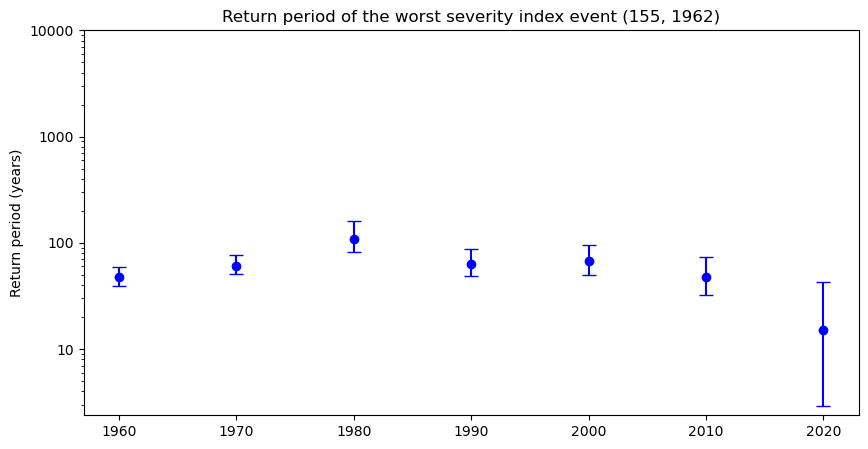

In [116]:
# plot the mean rp values with error bars for the 025 and 975 percentiles
plt.figure(figsize=(10, 5))

# plot the mean
plt.scatter(
    model_df_rl["decade"],
    model_df_rl["mean_rp (years)"],
    color="blue",
    label="Mean",
)

# plot the 025 and 975 percentiles
plt.errorbar(
    model_df_rl["decade"],
    model_df_rl["mean_rp (years)"],
    yerr=[
        model_df_rl["mean_rp (years)"] - model_df_rl["025_rp (years)"], # lower errors
        model_df_rl["975_rp (years)"] - model_df_rl["mean_rp (years)"], # upper errors
    ],
    fmt="none",
    ecolor="blue",
    capsize=5,
)

# set up a log yscale
plt.yscale("log")

# Set up the y ticks
plt.yticks([10, 100, 1000, 10000], ["10", "100", "1000", "10000"])

# set up the y axis labels
plt.ylabel("Return period (years)")

# find the year of the highest value for no exceedance days
# in the observed data
max_year = df_exceedance_days_obs.loc[
    df_exceedance_days_obs["severity"].idxmax()
].name

# print max year
print("The year with the greatest severity index is: ", max_year)

# # set up the title
# Set up the title
plt.title(
    f"Return period of the worst severity index event ({round(df_exceedance_days_obs['severity'].max())}, {max_year})"
)

Text(0.5, 1.0, 'Return period of the worst severity event (155, 1962)')

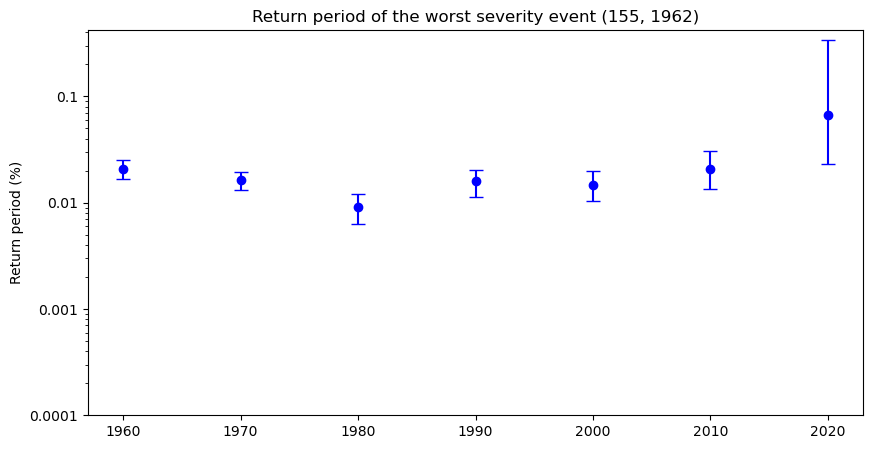

In [115]:
# Set up the figure
plt.figure(figsize=(10, 5))

# plot scatter of decade vs mean return period (%)
plt.scatter(
    model_df_rl["decade"],
    model_df_rl["mean_rp (%)"],
    color="blue",
    label="Mean",
)

# plot the 025 and 975 percentiles
plt.errorbar(
    model_df_rl["decade"],
    model_df_rl["mean_rp (%)"],
    yerr=[
        model_df_rl["mean_rp (%)"] - model_df_rl["975_rp (%)"], # lower errors
        model_df_rl["025_rp (%)"] - model_df_rl["mean_rp (%)"], # upper errors
    ],
    fmt="none",
    ecolor="blue",
    capsize=5,
)

# set up the yscale
plt.yscale("log")

# set up the yticks
plt.yticks([0.0001, 0.001, 0.01, 0.1], ["0.0001", "0.001", "0.01", "0.1"])

# set up the ylabel
plt.ylabel("Return period (%)")

# set up the title
plt.title(
    f"Return period of the worst severity event ({round(df_exceedance_days_obs['severity'].max())}, {max_year})"
)

Now we should detrend demand and then repeat. It's weird that there is this trend.

First plot the time series to explore the trend.

In [119]:
df_model_ondjfm.head()

,init_year,member,lead,data,data_c,hdd,cdd,UK_demand
330,1960,1,331,283.344633,10.194633,5.305367,0,39.022425
331,1960,1,332,284.247110,11.097110,4.402890,0,38.347726
332,1960,1,333,284.948156,11.798156,3.701844,0,37.823617
333,1960,1,334,284.529038,11.379038,4.120962,0,38.136953
334,1960,1,335,284.921268,11.771268,3.728732,0,37.843719


In [120]:
# subset the model to the correct years
winter_years = np.arange(1, 10 + 1)

# set up a new df to append to
df_model_ondjfm_wyear = pd.DataFrame()

# Loop over the winter years
for i, wyear in enumerate(winter_years):
    # Set up the leads to extract
    leads = np.arange(331 + (i * 360), 331 + 180 + (i * 360))

    # Extract the data
    df_model_leads_this = df_model_ondjfm[df_model_ondjfm["lead"].isin(leads)]

    # include a new column containing the winter year
    df_model_leads_this["winter_year"] = wyear

    # Append to the new df
    df_model_ondjfm_wyear = pd.concat([df_model_ondjfm_wyear, df_model_leads_this])

In [121]:
df_model_ondjfm_wyear.head()

,init_year,member,lead,data,data_c,hdd,cdd,UK_demand,winter_year
330,1960,1,331,283.344633,10.194633,5.305367,0,39.022425,1
331,1960,1,332,284.247110,11.097110,4.402890,0,38.347726,1
332,1960,1,333,284.948156,11.798156,3.701844,0,37.823617,1
333,1960,1,334,284.529038,11.379038,4.120962,0,38.136953,1
334,1960,1,335,284.921268,11.771268,3.728732,0,37.843719,1


In [124]:
# include effective dec year
df_model_ondjfm_wyear["effective_dec_year"] = df_model_ondjfm_wyear["init_year"] + df_model_ondjfm_wyear["winter_year"]

In [125]:
import scipy.stats as stats

# calculate the slopes
# create an empty array to store the values of slope and intercept
slopes = np.zeros([len(df_model_ondjfm_wyear["member"].unique()), len(df_model_ondjfm_wyear["winter_year"].unique())])
intercepts = np.zeros([len(df_model_ondjfm_wyear["member"].unique()), len(df_model_ondjfm_wyear["winter_year"].unique())])

# set up the unique members
members = df_model_ondjfm_wyear["member"].unique()

# set up the unique leads
leads = df_model_ondjfm_wyear["winter_year"].unique()

# loop over the unique members
for m, member in enumerate(members):
    for l, winter_year in enumerate(leads):
        # Extract the data for the member and the winter_year
        model_data_this = df_model_ondjfm_wyear[
            (df_model_ondjfm_wyear["member"] == member) & (df_model_ondjfm_wyear["winter_year"] == winter_year)
        ]

        # Fit a linear trend to the model data
        slope, intercept, r_value, p_value, std_err = stats.linregress(
            model_data_this["effective_dec_year"], model_data_this["UK_demand"]
        )

        # Store the slope and intercept
        slopes[m, l] = slope
        intercepts[m, l] = intercept

# flatten the slopes
slopes_flat = slopes.flatten()
intercepts_flat = intercepts.flatten()

# print the mean of the slopes_flat
print(f"Mean of slopes_flat: {np.mean(slopes_flat)}")

# print the 2.5% and 97.5% percentiles of the slopes_flat
print(f"2.5% percentile of slopes_flat: {np.percentile(slopes_flat, 2.5)}")
print(f"97.5% percentile of slopes_flat: {np.percentile(slopes_flat, 97.5)}")

Mean of slopes_flat: -0.022468317442175006
2.5% percentile of slopes_flat: -0.03072795292586674
97.5% percentile of slopes_flat: -0.014280818146399655


In [128]:
# now try pivoting the model data around the final point

# compute the linear trend
# as the mean of the slopes_flat and intercepts_flat
# for all the member and lead combinations
trend_line = np.mean(slopes_flat) *df_model_ondjfm_wyear["effective_dec_year"] + np.mean(intercepts_flat)

# Calculate the value of the trend line at the final point
trend_line_2017 = np.mean(slopes_flat) *df_model_ondjfm_wyear["effective_dec_year"].iloc[-1] + np.mean(intercepts_flat)

# Detrend the data by subtracting the trend line and adding back the final point value
df_model_ondjfm_wyear['UK_demand_dt'] =df_model_ondjfm_wyear['UK_demand'] - trend_line + trend_line_2017

In [132]:
# # remove this same trend form the obs data
# trend_line_interp = np.interp(
#     df_obs_tas.inde

In [150]:
trend_line_2017

np.float64(42.12910504577425)

<Axes: xlabel='time'>

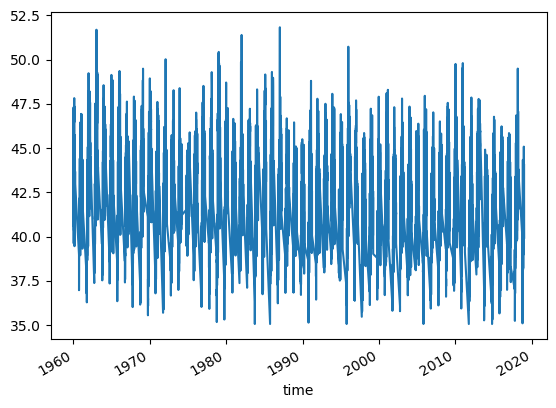

In [146]:
df_obs_tas["UK_demand"].plot()

In [141]:
type(df_model_ondjfm_wyear["effective_dec_year"])

pandas.core.series.Series

In [140]:
# format the effective_dec_year to a datetime object
df_model_ondjfm_wyear["effective_dec_year"] = pd.to_datetime(df_model_ondjfm_wyear["effective_dec_year"], format="%Y")

Text(0.5, 1.0, 'UK ONDJFM 10m wind speed 1979-2017')

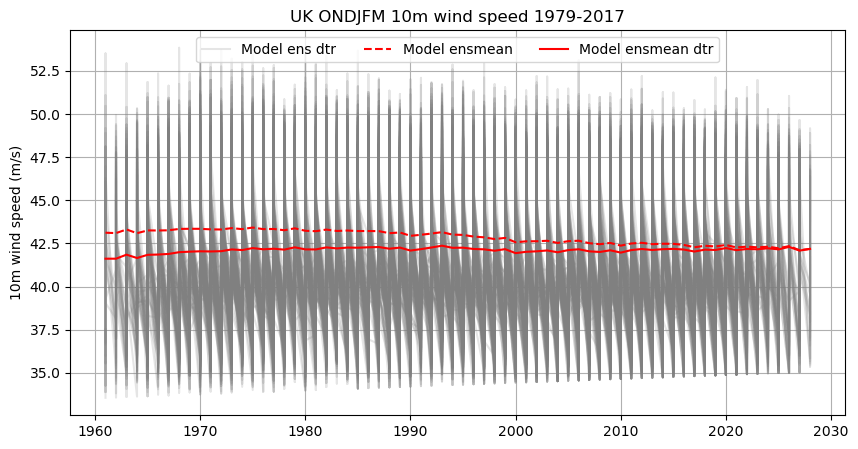

In [151]:
# set up a figure of size 10, 5
plt.figure(figsize=(10, 5))

# include gridlines and ticks
plt.grid(True)

# loop over and plot all of the unique member and winter_year combinations
for member in df_model_ondjfm_wyear["member"].unique():
    for winter_year in df_model_ondjfm_wyear["winter_year"].unique():
        
        model_data_this = df_model_ondjfm_wyear[
            (df_model_ondjfm_wyear["member"] == member) & (df_model_ondjfm_wyear["winter_year"] == winter_year)
        ]

        # if this is the first member and winter_year combination
        # include a label
        if (member == df_model_ondjfm_wyear["member"].unique()[0]) & (winter_year == df_model_ondjfm_wyear["winter_year"].unique()[0]):
            plt.plot(
                model_data_this["effective_dec_year"],
                model_data_this["UK_demand_dt"],
                color="gray",
                alpha=0.2,
                label="Model ens dtr",
            )

        plt.plot(
            model_data_this["effective_dec_year"],
            model_data_this["UK_demand_dt"],
            color="gray",
            alpha=0.2,
        )

# plot the ensemble mean of the model data (avg over member and winter_year)
model_df_avg = df_model_ondjfm_wyear.groupby("effective_dec_year").mean()

# reset the index
model_df_avg = model_df_avg.reset_index()

# plot the model ensmean not detrended
plt.plot(
    model_df_avg["effective_dec_year"],
    model_df_avg["UK_demand"],
    label="Model ensmean",
    color="red",
    linestyle="--",
)

# plot the model ensmean detrended
plt.plot(
    model_df_avg["effective_dec_year"],
    model_df_avg["UK_demand_dt"],
    label="Model ensmean dtr",
    color="red",
)

# # plot the observed data not detrended
# plt.plot(
#     df_obs_tas.index,
#     df_obs_tas["UK_demand"],
#     label="Obs",
#     color="black",
#     linestyle="--",
# )

# # plot the observed data detrended
# plt.plot(
#     df_obs_tas.index,
#     df_obs_tas["UK_demand_dt"],
#     label="Obs dtr",
#     color="black",
# )

# # plot the highest value for tas mon in black as a horizontal dashed line
# plt.axhline(y=df_obs_tas['UK_demand'].max(), color='black', linestyle='--', linewidth=0.8)

# # plot the highest value for tas mon in black as a horizontal line
# plt.axhline(y=df_obs_tas['UK_demand_dt'].max(), color='black', linewidth=0.8)

# include the legend centred at the top of the plot
plt.legend(loc="upper center", ncol=3)

# include a ylabel
plt.ylabel("10m wind speed (m/s)")

# include the title
plt.title("UK ONDJFM 10m wind speed 1979-2017")